In [1]:
import torch
from torch import nn
import torch.nn.functional as F
from torchdiffeq import odeint
from torch.distributions import Normal
from torch.distributions.kl import kl_divergence
from torch.utils.data import Dataset, DataLoader

import numpy as np

import random

import warnings

from copy import deepcopy

import matplotlib.pyplot as plt
from matplotlib.lines import Line2D

In [2]:
class OscillatorsDataset(Dataset):
    """
    Dampled Coupled Oscillators synthetic dataset.
    
    Produces data for the system
    
    |-spring-mass-spring-mass-spring-| w/ 'air' resistance
    
    where | are walls (i.e. immovable boundaries), described by
    
    f_i = k*(x_j - 2*x_i) - c*v_i
    
    for force f, displacements x, and velocity v, using Euler integration.
    
    Parameters
        n       : int, number of samples
        dt      : float, time step
        freq    : int, how frequently to sample (multiple of dt)
        samples : int, how many samples to take (multiples of freq)
                  (an extra sample is include for t=0)
    (possible) sampling parameters
        m1,m2   : masses
        x1,x2   : initial positions
        v1,v2   : initial velocities
        k       : (ideal) spring constant
        c       : 'air' resistance constant
    If a float is provided for a sampling parameter, it is fixed at that value;
    if a list is provided, it will be uniformly sampled from the range.

    The time step, freq and samples default to
        dt      : 0.01
        freq    : 10
        samples : 10
    n defaults to 1.
    
    The 'inputs' are the sampled parameters, i.e. if only the initial
    positions are left unspecified and the 'outputs' are the positions
    over time (x1(t),x2(t)).
    
    Output times are normalised to run 0 to 1, such that the first sample
    is always at time = 0 and the final is always at time = 1.
    """
    
    def __init__(self, config, train=True, verbose=True):

        # from config
        #   base simulator setup
        self.dt = config['simulator']['dt']
        self.freq = config['simulator']['sampling_freq']
        self.samples = config['simulator']['samples']
        #   system parameter dictionaries
        self.fixed = config['fixed']
        if train:
            self.varying = config['varying']
            self.n = config['train_examples']
        else:
            self.varying = config['eval_varying']
            self.n = config['eval_examples']
        
        # + 1 for the extra sample at t = 0
        self.total_steps = self.freq*self.samples + 1
        # normalised times
        self.times = torch.arange(0,self.samples+1,1)/(1.*self.samples)
        
        if verbose:
            if train:
                print('Training data generation...')
            else:
                print('Evaluation data generation...')
            print('Fixed paramters', self.fixed)
            print('Varying parameters', self.varying)
        
        self.data = []
        # generate data
        for _ in range(self.n):
            description, conditions = self.description_and_conditions()
            output = self.single_run(conditions)
            self.data.append((description, output, self.times))
        
    def __getitem__(self, index):
        return self.data[index]
    
    def __len__(self):
        return self.n
    
    def description_and_conditions(self):
        """
        Return a sample of initial conditions, with those specified at
        input being fixed and the unspecified being the description, too.
        """
        
        conditions = deepcopy(self.fixed)
        for key in self.varying:
            if key in conditions:
                warnings.warn('System parameter defined in both fixed and varying configs')
            low = min(self.varying[key])
            high = max(self.varying[key])
            conditions[key] = np.random.uniform(low,high)
        
        # the description is the varying part
        description = [conditions[v] for v in self.varying]
        
        return torch.FloatTensor(description), conditions
    
    def single_run(self, conditions):
        x1, x2 = conditions['x1'], conditions['x2']
        v1, v2 = conditions['v1'], conditions['v2']
        m1, m2 = conditions['m1'], conditions['m2']
        c, k = conditions['c'], conditions['k']
        output = []
        for step in range(self.total_steps):
            if step % self.freq == 0:
                output.append([x1,x2])
            
            a1 = k*(x2-2*x1) - c*v1
            a2 = k*(x1-2*x2) - c*v2
            
            x1 += self.dt*v1
            x2 += self.dt*v2
            v1 += self.dt*a1
            v2 += self.dt*a2
    
        return torch.FloatTensor(output)

In [3]:
class obs_encoder(nn.Module):
    """
    Takes raw observations (x_i, t_i) and produces a representation r_i.
    """
    
    def __init__(self,config):
        super(obs_encoder, self).__init__()
        
        obs_dim = config['x_dim']
        h_dim = config['obs_enc_h_dim']
        r_dim = config['r_dim']
        
        layers = [
            nn.Linear(obs_dim+1,h_dim),
            nn.ReLU(),
            nn.Linear(h_dim,h_dim),
            nn.ReLU(),
            nn.Linear(h_dim,r_dim)
        ]
        
        self.layers = torch.nn.Sequential(*layers)
    
    def forward(self, observations, times):
        return self.layers(torch.cat([observations, times.unsqueeze(-1)],-1))

In [4]:
class pi_encoder(nn.Module):
    """
    Takes the privileged information signal and produces a representation r_p.
    """
    def __init__(self, config):
        super(pi_encoder, self).__init__()
        
        pi_dim = config['pi_dim']
        h_dim = config['pi_enc_h_dim']
        r_dim = config['pi_r_dim']
        
        layers = [
            nn.Linear(pi_dim,h_dim),
            nn.ReLU(),
            nn.Linear(h_dim,h_dim),
            nn.ReLU(),
            nn.Linear(h_dim,r_dim)
        ]
        
        self.layers = torch.nn.Sequential(*layers)
    
    def forward(self, x):
        return self.layers(x)

In [5]:
class r_aggregator(nn.Module):
    """
    Takes mixed representations from observations and privileged information and
    produces a single task representation.
    
    In evaluation mode privileged information should not be used and a warning will
    given if this is attempted.
    """
    def __init__(self, config):
        super(r_aggregator, self).__init__()
        
        obs_r_dim = config['r_dim']
        pi_r_dim = config['pi_r_dim']
        h_dim = config['agg_h_dim']
        
        self.aggregators = config['aggregators']
        
        for agg in self.aggregators:
            if agg not in ['mean','max','min','logsumexp']:
                raise ValueError(f'Aggregator {agg} is not supported.')
        
        # when using privileged information we combine the representations with a small ResNet
        layers = [
            nn.Linear(obs_r_dim*len(self.aggregators)+pi_r_dim,h_dim),
            nn.ReLU(),
            nn.Linear(h_dim,h_dim),
            nn.ReLU(),
            nn.Linear(h_dim,obs_r_dim*len(self.aggregators))
        ]
        
        self.layers = torch.nn.Sequential(*layers)
        
    def aggregate(self, obs_r):
        # concatentate the aggregator outputs
        agg = []
        if 'max' in self.aggregators:
            agg.append(torch.max(obs_r,0).values)
        if 'min' in self.aggregators:
            agg.append(torch.min(obs_r,0).values)
        if 'logsumexp' in self.aggregators:
            agg.append(torch.logsumexp(obs_r,0))
        if 'mean' in self.aggregators:
            agg.append(torch.mean(obs_r,0))
        
        return torch.cat(agg, 0)
        
    def forward(self, r_i, r_p=None):
        if not self.training and r_p is not None:
            warnings.warn('Privileged information provided to the aggregator in evaluation mode.')
        
        # aggregate observations
        r_obs = self.aggregate(r_i)
        
        # if we have privileged information, use the resnet
        # r_obs' = r_obs + f(r_obs, r_p)
        if r_p is not None:
            r_obs = r_obs + self.layers(torch.cat([r_obs, r_p], -1))
        
        return r_obs

In [6]:
class r_to_z(nn.Module):
    """
    From task representation to global latent variable.
    """
    def __init__(self, config):
        super(r_to_z, self).__init__()
        
        aggregated_r_dim = config['r_dim'] * len(config['aggregators'])
        h_dim = config['r_to_z_h_dim']
        z_dim = config['z_dim']
        
        layers = [
            nn.Linear(aggregated_r_dim,h_dim),
            nn.ReLU(),
            nn.Linear(h_dim,h_dim),
            nn.ReLU()
        ]
        
        self.layers = torch.nn.Sequential(*layers)
        
        self.h_to_mu = torch.nn.Linear(h_dim, z_dim)
        self.h_to_sigma = torch.nn.Linear(h_dim, z_dim)
        
    def forward(self, r):
        h = self.layers(r)
        mu = self.h_to_mu(h)
        sigma = 0.1 + 0.9*torch.sigmoid(self.h_to_sigma(h))
        
        return Normal(mu, sigma)

In [7]:
class z_to_L0(nn.Module):
    """
    Use a sample from the global latent variable to produce the initial L value.
    """
    def __init__(self,config):
        super(z_to_L0, self).__init__()
        
        L_dim = config['L_dim']
        z_dim = config['z_dim']
        h_dim = config['z_to_L_h_dim']
        
        layers = [
            nn.Linear(z_dim,h_dim),
            nn.ReLU(),
            nn.Linear(h_dim,h_dim),
            nn.ReLU(),
            nn.Linear(h_dim,L_dim)
        ]
        
        self.layers = torch.nn.Sequential(*layers)
        
    def forward(self, z_sample):
        return self.layers(z_sample)

In [8]:
class conditional_ODE_func(nn.Module):
    """
    Conditional derivative function.
    
    Input is a concatentation of the ODE latent state and the global latent variable sample,
    and the time
        (L || z, t)
    Output is the derivative at that time
        (dL || dz)
    with dz set to 0.
    
    This is a 'hacky' way to condition the ODE without letting the sample varying.
    """
    
    def __init__(self,config):
        super(conditional_ODE_func, self).__init__()
        
        L_dim = config['L_dim']
        z_dim = config['z_dim']
        h_dim = config['ode_h_dim']
        
        layers = [
            torch.nn.Linear(L_dim+z_dim+1,h_dim),
            torch.nn.Softplus(),
            torch.nn.Linear(h_dim,h_dim),
            torch.nn.Softplus(),
            torch.nn.Linear(h_dim,L_dim)
        ]
        
        self.latent_func = torch.nn.Sequential(*layers)
        
        self.L_dim = L_dim
        
        self.nfe = 0
    
    def forward(self, t, L_z):
        self.nfe += 1
        z = L_z[self.L_dim:]
        L_z_t = torch.cat([L_z,t.unsqueeze(-1)])
        dL = self.latent_func(L_z_t)
        dz = torch.zeros_like(z)
        
        return torch.cat([dL,dz])

In [9]:
class decoder(nn.Module):
    """
    Produce an output from the ODE latent state and the global latent variable sample.
    """
    def __init__(self, config):
        super(decoder, self).__init__()
        
        L_dim = config['L_dim']
        z_dim = config['z_dim']
        h_dim = config['dec_h_dim']
        out_dim = config['x_dim']
        
        layers = [
            torch.nn.Linear(L_dim+z_dim,h_dim),
            torch.nn.ReLU(),
            torch.nn.Linear(h_dim,h_dim),
            torch.nn.ReLU()
        ]
        
        self.shared_layers = torch.nn.Sequential(*layers)
        
        self.hidden_to_mu = torch.nn.Linear(h_dim, out_dim)
        self.hidden_to_sigma = torch.nn.Linear(h_dim, out_dim)
        
    def forward(self, L_z_t):
        
        hidden = self.shared_layers(L_z_t)
        mu = self.hidden_to_mu(hidden)
        sigma = 0.1 + 0.9*F.softplus(self.hidden_to_sigma(hidden))
        return Normal(mu, sigma)

In [10]:
class LUPI_NDP(nn.Module):
    
    def __init__(self, config):

        super(LUPI_NDP, self).__init__()
        
        self.observations_encoder = obs_encoder(config)
        self.privileged_info_encoder = pi_encoder(config)
        self.representation_aggregator = r_aggregator(config)
        self.representation_to_global_latent = r_to_z(config)
        self.global_latent_to_initial_value = z_to_L0(config)
        self.odefunc = conditional_ODE_func(config)
        self.decoder = decoder(config)
        
    def forward(self, observations, times, p_info, context_idx, target_idx):
        if self.training:
            # encode
            r_i = self.observations_encoder(observations, times)
            r_p = self.privileged_info_encoder(p_info)
            # aggregate
            r_C = self.representation_aggregator(r_i[context_idx],None)
            r_T = self.representation_aggregator(r_i[target_idx],r_p)
            # parametrise
            z_C = self.representation_to_global_latent(r_C)
            z_T = self.representation_to_global_latent(r_T)
            # sample (from target Z during training)
            z_ = z_T.rsample()
            # initialise and evolve
            L0 = self.global_latent_to_initial_value(z_)
            L_z = torch.cat([L0,z_])
            ################ this bit won't work with batching yet
            L_z_t = odeint(self.odefunc, L_z, times[target_idx])
            return z_C, z_T, self.decoder(L_z_t)
        
        else:
            # encode
            r_i = self.observations_encoder(observations[context_idx],
                                            times[context_idx])
            # aggregate
            r_C = self.representation_aggregator(r_i,None)
            # parametrise
            z_C = self.representation_to_global_latent(r_C)
            # sample (from context Z during eval.)
            z_ = z_C.rsample()
            # initialise and evolve
            L0 = self.global_latent_to_initial_value(z_)
            L_z = torch.cat([L0,z_])
            ################ this bit won't work with batching yet
            L_z_t = odeint(self.odefunc, L_z, times[target_idx].squeeze())
            return self.decoder(L_z_t)

In [11]:
config = {
    # data stuff
    'train_examples' : 500,
    'train_val_split' : 0.8,
    'eval_examples' : 100,
    'simulator' : {
        'dt' : 0.01,
        'sampling_freq' : 20,
        'samples' : 50
    },
    'fixed' : {
        'm1' : 1,
        'm2' : 1,
        'x1' : 1,
        'x2' : -1,
        'v1' : 0,
        'v2' : 0,
        'c' : 1
    },
    'varying' : {
        'k' : [0.2, 1.]
    },
    'eval_varying' : {
        'k' : [0.2, 1.]
    },
    # model stuff
    'x_dim' : 2,
    'obs_enc_h_dim' : 16,
    'r_dim': 16,
    'pi_dim': 1,
    'pi_enc_h_dim': 16,
    'pi_r_dim': 16,
    'aggregators': ['logsumexp', 'mean'],
    'agg_h_dim': 16,
    'r_to_z_h_dim': 16,
    'z_dim': 16,
    'z_to_L_h_dim': 16,
    'L_dim': 16,
    'ode_h_dim': 16,
    'dec_h_dim': 16,
    # training details
    'lr' : 1e-3,
    'epochs' : 100,
    'val_and_print' : 10,
    'context_range' : [5,10],
    'target_range' : [15,51] # superset of context
}

Training data generation...
Fixed paramters {'m1': 1, 'm2': 1, 'x1': 1, 'x2': -1, 'v1': 0, 'v2': 0, 'c': 1}
Varying parameters {'k': [0.2, 1.0]}
Evaluation data generation...
Fixed paramters {'m1': 1, 'm2': 1, 'x1': 1, 'x2': -1, 'v1': 0, 'v2': 0, 'c': 1}
Varying parameters {'k': [0.2, 1.0]}


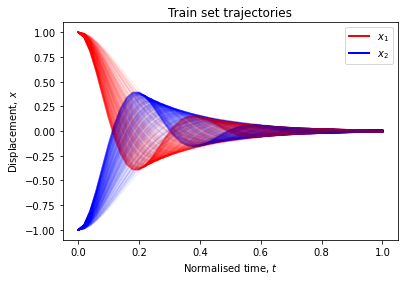

In [12]:
# datasets
train_val_set = OscillatorsDataset(config)
train_set = train_val_set[:int(config['train_examples']*config['train_val_split'])]
val_set = train_val_set[int(config['train_examples']*config['train_val_split']):]
eval_set = OscillatorsDataset(config, train=False)

train_examples = len(train_set)
val_examples = len(val_set)
eval_examples = len(eval_set)

# loaders
train_loader = DataLoader(train_set, batch_size=1)
val_loader = DataLoader(val_set, batch_size=1)
eval_loader = DataLoader(eval_set, batch_size=1)

# sanity plot
for inputs, labels, times in train_loader:
    plt.plot(times[0], labels[0,:,0], alpha=0.03, c='r')
    plt.plot(times[0], labels[0,:,1], alpha=0.03, c='b')
plt.title('Train set trajectories')
custom_lines = [Line2D([0], [0], color='r', lw=2),
                Line2D([0], [0], color='b', lw=2)]
plt.legend(custom_lines, ['$x_1$', '$x_2$'])
plt.xlabel('Normalised time, $t$')
plt.ylabel('Displacement, $x$')
plt.show()

In [13]:
# model and optimizer
model = LUPI_NDP(config)
optimizer = torch.optim.Adam(model.parameters(), lr=config['lr'])
context_range = range(min(config['context_range']),max(config['context_range']))
target_range = range(min(config['target_range']),max(config['target_range']))

#### Single pass (untrained)

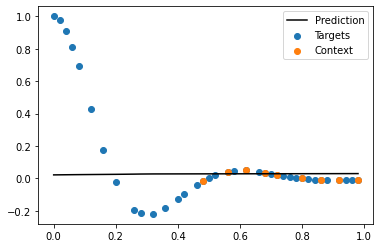

In [14]:
pi, x, times = next(iter(train_loader))

context_size = random.sample(context_range,1)[0] # some number in the range 5 to 9
target_size = random.sample(target_range,1)[0] # some number in the range 15 to 50
target_idx = random.sample(range(config['simulator']['samples']),target_size) # a set of indices
context_idx = random.sample(target_idx, context_size) # a subset of the target indices
target_idx.sort()
context_idx.sort()
target_idx = torch.LongTensor(target_idx)
context_idx = torch.LongTensor(context_idx)

# haven't sorted out time sampled batching properly yet so squeezing out the batch dim
zC,zT,preds = model(x.squeeze(0), times.squeeze(0), pi.squeeze(0), context_idx, target_idx)
plt.scatter(times.squeeze(0)[target_idx],x.squeeze(0)[target_idx][:,0], label='Targets')
plt.scatter(times.squeeze(0)[context_idx],x.squeeze(0)[context_idx][:,0], label='Context')
plt.plot(times.squeeze(0)[target_idx],preds.loc[:,0].detach(), color='k', label='Prediction')
plt.legend()
plt.show()

### Training

In [15]:
for epoch in range(config['epochs']):
    total_epoch_loss = 0
    recon_epoch_loss = 0
    kl_epoch_loss = 0
    # training loop
    for i,batch in enumerate(train_loader):
        optimizer.zero_grad()
        
        pi, x, times = batch
        
        # context/target idx
        context_size = random.sample(context_range,1)[0]
        target_size = random.sample(target_range,1)[0]
        # during training, context are a subset of targets
        target_idx = random.sample(range(config['simulator']['samples']),target_size)
        context_idx = random.sample(target_idx, context_size)
        target_idx.sort()
        context_idx.sort()
        target_idx = torch.LongTensor(target_idx)
        context_idx = torch.LongTensor(context_idx)
        
        zC, zT, preds = model(x.squeeze(0),
                              times.squeeze(0),
                              pi.squeeze(0),
                              context_idx,
                              target_idx)

        # reconstruction term
        log_likelihood = preds.log_prob(x.squeeze(0)[target_idx]).sum()
        # kl term
        kl = kl_divergence(zT, zC).sum()
        
        loss = -log_likelihood + kl

        loss.backward()
        
        optimizer.step()
        
        total_epoch_loss += loss.item()
        recon_epoch_loss += -log_likelihood.item()
        kl_epoch_loss += kl.item()
    # validation and printing loop
    with torch.no_grad():
        if (epoch+1) % config['val_and_print'] == 0:
            model.eval()
            val_recon = 0

            for i, batch in enumerate(val_loader):
                pi, x, times = batch

                # context/target idx
                context_size = random.sample(context_range,1)[0]
                # during eval, context and targets are disjoint and targets are all but context
                context_idx = random.sample(range(config['simulator']['samples']), context_size)
                target_idx = list(set(range(config['simulator']['samples']))-set(context_idx))
                context_idx.sort()
                target_idx = torch.LongTensor(target_idx)
                context_idx = torch.LongTensor(context_idx)

                preds = model(x.squeeze(0),times.squeeze(0),pi.squeeze(0),
                              context_idx,target_idx)
                log_likelihood = preds.log_prob(x.squeeze(0)[target_idx]).mean()

                val_recon += -log_likelihood.item()
            print_string = (
                "Epoch {0:d} \t"
                "Train {1:.0f} / {2:.0f} / {3:.0f} \t"
                "Val {4:.0f}"
            ).format(epoch+1,
                     total_epoch_loss/train_examples, recon_epoch_loss/train_examples,
                     kl_epoch_loss/train_examples,val_recon/val_examples)
            print(print_string)
            model.train()

Epoch 10 	Train -62 / -64 / 2 	Val -1
Epoch 20 	Train -74 / -77 / 4 	Val -0
Epoch 30 	Train -76 / -79 / 3 	Val -0
Epoch 40 	Train -79 / -82 / 3 	Val -0
Epoch 50 	Train -81 / -84 / 3 	Val -0
Epoch 60 	Train -80 / -83 / 3 	Val -0
Epoch 70 	Train -83 / -85 / 3 	Val -0
Epoch 80 	Train -83 / -85 / 2 	Val -0
Epoch 90 	Train -85 / -87 / 3 	Val -0
Epoch 100 	Train -84 / -87 / 2 	Val -1


### Evaluation

In [172]:
z_samples = 16

In [173]:
with torch.no_grad():
    
    eval_error = 0.
    pi_error = 0.

    for i, batch in enumerate(eval_loader):
        # get example
        pi, x, times = batch
        
        pi_preds = []
        nopi_preds = []

        context_range = range(5,10)
        target_range = range(15,51)

        context_size = random.sample(context_range,1)[0] # some number in the range 5 to 9
        target_size = random.sample(target_range,1)[0] # some number in the range 15 to 50
        target_idx = list(range(config['simulator']['samples'])) # a set of indices
        context_idx = random.sample(target_idx, context_size) # a subset of the target indices
        target_idx.sort()
        context_idx.sort()
        target_idx = torch.LongTensor(target_idx)
        context_idx = torch.LongTensor(context_idx)
        
        for _ in range(z_samples):
            model.train()
            _,_,train_preds = model(x.squeeze(0), times.squeeze(0), pi.squeeze(0), context_idx, target_idx)
            pi_preds.append(train_preds.loc[:,0].detach())
            model.eval()
            eval_preds = model(x.squeeze(0), times.squeeze(0), pi.squeeze(0), context_idx, target_idx)
            nopi_preds.append(eval_preds.loc[:,0].detach())
        pi_mean = torch.stack(pi_preds,0).mean(0)
        eval_mean = torch.stack(nopi_preds,0).mean(0)
        
        eval_error += torch.mean((eval_mean - x.squeeze(0)[:-1,0])**2).item()
        pi_error += torch.mean((pi_mean - x.squeeze(0)[:-1,0])**2).item()

eval_error = eval_error/len(eval_loader)
pi_error = pi_error/len(eval_loader)
print('MSE without PI: ', eval_error)
print('MSE with PI: ', pi_error)

MSE without PI:  0.01086099592735991
MSE with PI:  0.0005729159392649308


## Plots from the trained model

#### Single sample trajectory on an example from the training set

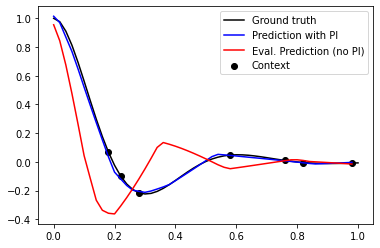

In [23]:
pi, x, times = next(iter(train_loader))

context_range = range(5,10)
target_range = range(15,51)

context_size = random.sample(context_range,1)[0] # some number in the range 5 to 9
target_size = random.sample(target_range,1)[0] # some number in the range 15 to 50
target_idx = list(range(config['simulator']['samples'])) # a set of indices
context_idx = random.sample(target_idx, context_size) # a subset of the target indices
target_idx.sort()
context_idx.sort()
target_idx = torch.LongTensor(target_idx)
context_idx = torch.LongTensor(context_idx)

# haven't sorted out time sampled batching properly yet so squeezing out the batch dim
model.train()
zC,zT,train_preds = model(x.squeeze(0), times.squeeze(0), pi.squeeze(0), context_idx, target_idx)
model.eval()
eval_preds = model(x.squeeze(0), times.squeeze(0), pi.squeeze(0), context_idx, target_idx)
plt.plot(times.squeeze(0), x.squeeze(0)[:,0], label='Ground truth', color='k')
plt.scatter(times.squeeze(0)[context_idx],x.squeeze(0)[context_idx][:,0], label='Context', color='k')
plt.plot(times.squeeze(0)[target_idx],train_preds.loc[:,0].detach(), color='b', label='Prediction with PI')
plt.plot(times.squeeze(0)[target_idx],eval_preds.loc[:,0].detach(), color='r', label='Eval. Prediction (no PI)')
plt.legend()
plt.show()

#### Many sample trajectories on an example from training set
(Note the context and target sets are fixed over the samples)

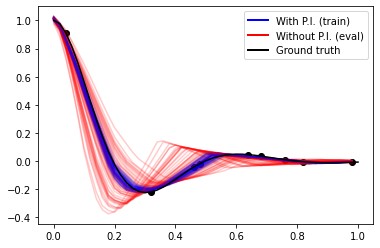

In [18]:
for _ in range(50):
    # haven't sorted out time sampled batching properly yet so squeezing out the batch dim
    model.train()
    zC,zT,train_preds = model(x.squeeze(0), times.squeeze(0), pi.squeeze(0), context_idx, target_idx)
    model.eval()
    eval_preds = model(x.squeeze(0), times.squeeze(0), pi.squeeze(0), context_idx, target_idx)
    plt.plot(times.squeeze(0)[target_idx],train_preds.loc[:,0].detach(), color='b', alpha=0.2)
    plt.plot(times.squeeze(0)[target_idx],eval_preds.loc[:,0].detach(), color='r', alpha=0.2)
plt.plot(times.squeeze(0), x.squeeze(0)[:,0], label='Ground truth', color='k')
plt.scatter(times.squeeze(0)[context_idx],x.squeeze(0)[context_idx][:,0], label='Context',color='k')
plt.legend()
custom_lines = [Line2D([0], [0], color='b', lw=2),
                Line2D([0], [0], color='r', lw=2),
                Line2D([0], [0], color='k', lw=2)]
plt.legend(custom_lines, ['With P.I. (train)', 'Without P.I. (eval)', 'Ground truth'])
plt.show()

#### Mean trajectory with confidence intervals for the example above

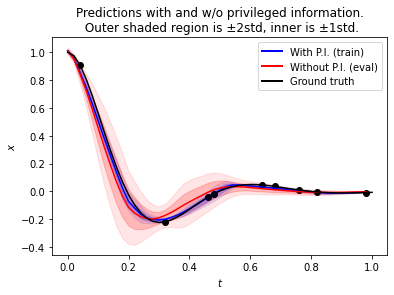

In [19]:
# sample a bunch of predictions
z_samples = 50
pi_preds = []
nopi_preds = []
for _ in range(z_samples):
    # haven't sorted out time sampled batching properly yet so squeezing out the batch dim
    model.train()
    _,_,train_preds = model(x.squeeze(0), times.squeeze(0), pi.squeeze(0), context_idx, target_idx)
    pi_preds.append(train_preds.loc[:,0].detach())
    model.eval()
    eval_preds = model(x.squeeze(0), times.squeeze(0), pi.squeeze(0), context_idx, target_idx)
    nopi_preds.append(eval_preds.loc[:,0].detach())
pi_mean = torch.stack(pi_preds,0).mean(0)
pi_std = torch.stack(pi_preds,0).std(0)
eval_mean = torch.stack(nopi_preds,0).mean(0)
eval_std = torch.stack(nopi_preds,0).std(0)

# plot ±2 std and ±1 std as transparent fills
plt.fill_between(times.squeeze(0)[target_idx],eval_mean+2*eval_std,eval_mean-2*eval_std, alpha = 0.1, color='r')
plt.fill_between(times.squeeze(0)[target_idx],pi_mean+2*pi_std,pi_mean-2*pi_std, alpha = 0.1, color='b')
plt.fill_between(times.squeeze(0)[target_idx],eval_mean+eval_std,eval_mean-eval_std, alpha = 0.2, color='r')
plt.fill_between(times.squeeze(0)[target_idx],pi_mean+pi_std,pi_mean-pi_std, alpha = 0.2, color='b')
# plot means over the top
plt.plot(times.squeeze(0)[target_idx],pi_mean,color='b')
plt.plot(times.squeeze(0)[target_idx],eval_mean,color='r')
# ground truth in black with context dots
plt.plot(times.squeeze(0), x.squeeze(0)[:,0], label='Ground truth', color='k')
plt.scatter(times.squeeze(0)[context_idx],x.squeeze(0)[context_idx][:,0], label='Context',color='k')
custom_lines = [Line2D([0], [0], color='b', lw=2),
                Line2D([0], [0], color='r', lw=2),
                Line2D([0], [0], color='k', lw=2)]
plt.legend(custom_lines, ['With P.I. (train)', 'Without P.I. (eval)', 'Ground truth'])
plt.title('Predictions with and w/o privileged information.\n Outer shaded region is ±2std, inner is ±1std.')
plt.xlabel('$t$')
plt.ylabel('$x$')
plt.show()

#### Mean trajectory with confidence intervals for an evaluation set sample

In [20]:
eval_iter = iter(eval_loader)

0.8207189440727234


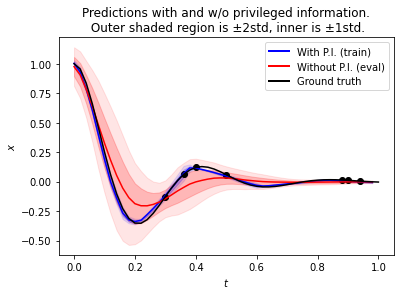

In [158]:
pi, x, times = next(eval_iter)

print('P.I. = ', pi.item())

context_range = range(5,10)
target_range = range(15,51)

context_size = random.sample(context_range,1)[0] # some number in the range 5 to 9
target_size = random.sample(target_range,1)[0] # some number in the range 15 to 50
target_idx = list(range(config['simulator']['samples'])) # a set of indices
context_idx = random.sample(target_idx, context_size) # a subset of the target indices
target_idx.sort()
context_idx.sort()
target_idx = torch.LongTensor(target_idx)
context_idx = torch.LongTensor(context_idx)

# sample a bunch of predictions
z_samples = 50
pi_preds = []
nopi_preds = []
for _ in range(z_samples):
    # haven't sorted out time sampled batching properly yet so squeezing out the batch dim
    model.train()
    _,_,train_preds = model(x.squeeze(0), times.squeeze(0), pi.squeeze(0), context_idx, target_idx)
    pi_preds.append(train_preds.loc[:,0].detach())
    model.eval()
    eval_preds = model(x.squeeze(0), times.squeeze(0), pi.squeeze(0), context_idx, target_idx)
    nopi_preds.append(eval_preds.loc[:,0].detach())
pi_mean = torch.stack(pi_preds,0).mean(0)
pi_std = torch.stack(pi_preds,0).std(0)
eval_mean = torch.stack(nopi_preds,0).mean(0)
eval_std = torch.stack(nopi_preds,0).std(0)

# plot ±2 std and ±1 std as transparent fills
plt.fill_between(times.squeeze(0)[target_idx],eval_mean+2*eval_std,eval_mean-2*eval_std, alpha = 0.1, color='r')
plt.fill_between(times.squeeze(0)[target_idx],pi_mean+2*pi_std,pi_mean-2*pi_std, alpha = 0.1, color='b')
plt.fill_between(times.squeeze(0)[target_idx],eval_mean+eval_std,eval_mean-eval_std, alpha = 0.2, color='r')
plt.fill_between(times.squeeze(0)[target_idx],pi_mean+pi_std,pi_mean-pi_std, alpha = 0.2, color='b')
# plot means over the top
plt.plot(times.squeeze(0)[target_idx],pi_mean,color='b')
plt.plot(times.squeeze(0)[target_idx],eval_mean,color='r')
# ground truth in black with context dots
plt.plot(times.squeeze(0), x.squeeze(0)[:,0], label='Ground truth', color='k')
plt.scatter(times.squeeze(0)[context_idx],x.squeeze(0)[context_idx][:,0], label='Context',color='k')
custom_lines = [Line2D([0], [0], color='b', lw=2),
                Line2D([0], [0], color='r', lw=2),
                Line2D([0], [0], color='k', lw=2)]
plt.legend(custom_lines, ['With P.I. (train)', 'Without P.I. (eval)', 'Ground truth'])
plt.title('Predictions with and w/o privileged information.\n Outer shaded region is ±2std, inner is ±1std.')
plt.xlabel('$t$')
plt.ylabel('$x$')
plt.show()

### Calibration & sharpness
#### Single example calibration

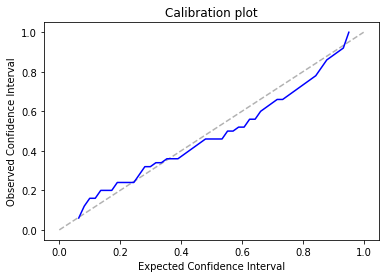

In [82]:
observed_confidence = Normal(eval_mean, eval_std).cdf(x.squeeze(0)[:-1,0])

# add perfect line
plt.plot([0,1],[0,1], c='black', ls='--', alpha=0.3)
data = observed_confidence.numpy()
# evaluate the histogram
values, base = np.histogram(data, bins=50)
#evaluate the cumulative
cumulative = np.cumsum(values)/len(data)
# plot the cumulative function
plt.plot(base[:-1], cumulative, c='blue')

plt.title('Calibration plot')
plt.xlabel('Expected Confidence Interval')
plt.ylabel('Observed Confidence Interval')
plt.show()

#### Over the full test set

In [187]:
z_samples = 16

First get the observed confidence levels and calculate the sharpness

In [ ]:
with torch.no_grad():
    model.eval()
    
    eval_observed_confidences = []
    pi_observed_confidences = []
    eval_sharpness = 0
    pi_sharpness = 0

    for i, batch in enumerate(eval_loader):
        # get example
        pi, x, times = batch
        
        pi_preds = []
        nopi_preds = []

        context_range = range(5,10)
        target_range = range(15,51)

        context_size = random.sample(context_range,1)[0] # some number in the range 5 to 9
        target_size = random.sample(target_range,1)[0] # some number in the range 15 to 50
        target_idx = list(range(config['simulator']['samples'])) # a set of indices
        context_idx = random.sample(target_idx, context_size) # a subset of the target indices
        target_idx.sort()
        context_idx.sort()
        target_idx = torch.LongTensor(target_idx)
        context_idx = torch.LongTensor(context_idx)
        
        for _ in range(z_samples):
            model.train()
            _,_,train_preds = model(x.squeeze(0), times.squeeze(0), pi.squeeze(0), context_idx, target_idx)
            pi_preds.append(train_preds.loc[:,0].detach())
            model.eval()
            eval_preds = model(x.squeeze(0), times.squeeze(0), pi.squeeze(0), context_idx, target_idx)
            nopi_preds.append(eval_preds.loc[:,0].detach())
        pi_mean = torch.stack(pi_preds,0).mean(0)
        pi_std = torch.stack(pi_preds,0).std(0)
        eval_mean = torch.stack(nopi_preds,0).mean(0)
        eval_std = torch.stack(nopi_preds,0).std(0)
        
        eval_observed_confidences.append(Normal(eval_mean, eval_std).cdf(x.squeeze(0)[:-1,0]))
        pi_observed_confidences.append(Normal(pi_mean, pi_std).cdf(x.squeeze(0)[:-1,0]))
        eval_sharpness += torch.mean(eval_std).item()
        pi_sharpness += torch.mean(pi_std).item()
    
    model.train()
eval_sharpness = eval_sharpness/len(eval_loader)
pi_sharpness = pi_sharpness/len(eval_loader)
print('Sharpness without PI: ', eval_sharpness)
print('Sharpness with PI: ', pi_sharpness)

Then find the mean and std over the cumulative histogram

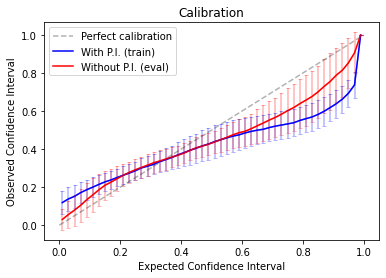

In [175]:
ev_cum = []
pi_cum = []
for ev, pi in zip(eval_observed_confidences, pi_observed_confidences):
    ev_d, pi_d = ev.numpy(), pi.numpy()
    
    ev_v, ev_b = np.histogram(ev_d, bins=50, range=(0.,1.))
    pi_v, pi_b = np.histogram(pi_d, bins=50, range=(0.,1.))
    
    ev_cum.append(np.cumsum(ev_v)/len(ev_d))
    pi_cum.append(np.cumsum(pi_v)/len(pi_d))
ev_cum_mean = np.mean(ev_cum, 0)
ev_cum_std = np.std(ev_cum,0)
pi_cum_mean = np.mean(pi_cum, 0)
pi_cum_std = np.std(pi_cum,0)

# add perfect line
plt.plot([0,1],[0,1], c='black', ls='--', alpha=0.3, label='Perfect calibration')

plt.plot((pi_b[:-1]+pi_b[1:])/2, pi_cumulative, c='blue', label='With P.I. (train)')
plt.plot((pi_b[:-1]+pi_b[1:])/2, eval_cumulative, c='red', label='Without P.I. (eval)')

plt.legend()

# plot the cumulative function
plt.errorbar((pi_b[:-1]+pi_b[1:])/2, pi_cum_mean, yerr=pi_cum_std, c='blue', alpha=0.3, capsize=2., label='With P.I. (train)')
plt.errorbar((pi_b[:-1]+pi_b[1:])/2, ev_cum_mean, yerr=ev_cum_std, c='red', alpha=0.3, capsize=2., label='Without P.I. (eval)')
plt.title('Calibration over the test set with standard deviations.')
plt.xlabel('Expected Confidence Interval')
plt.ylabel('Observed Confidence Interval')
plt.show()

Finally, calculate the calibration error

In [186]:
print('Calibration error with PI: ', (((pi_b[:-1]+pi_b[1:])/2 - pi_cum_mean)**2).sum())
print('Calibration error without PI: ', (((pi_b[:-1]+pi_b[1:])/2 - ev_cum_mean)**2).sum())

Calibration error with PI:  1.1086109507683273
Calibration error without PI:  0.41891779592704864
